In [ ]:
# default_exp modeling.seq2seq.translation

In [ ]:
#all_slow

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# modeling.seq2seq.translation

> This module contains custom models, custom splitters, etc... translation tasks.

In [ ]:
#export
import torch
from datasets import list_datasets, load_dataset
from transformers import *
from fastai.text.all import *

from blurr.utils import *
from blurr.data.core import get_blurr_tfm
from blurr.data.seq2seq.core import *
from blurr.data.seq2seq.translation import *
from blurr.modeling.core import *
from blurr.modeling.seq2seq.core import *

logging.set_verbosity_error()

In [ ]:
#hide
import pdb

from nbdev.showdoc import *
from fastcore.test import *

from fastai import __version__ as fa_version
from torch import __version__ as pt_version
from transformers import __version__ as hft_version

print(f'Using pytorch {pt_version}')
print(f'Using fastai {fa_version}')
print(f'Using transformers {hft_version}')

Using pytorch 1.8.1+cu102
Using fastai 2.3.1
Using transformers 4.5.1


In [ ]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


## Translation

Translation tasks attempt to convert text in one language into another

### Prepare the data

In [ ]:
ds = load_dataset('wmt16', 'de-en', split='train[:1%]')

Reusing dataset wmt16 (/home/wgilliam/.cache/huggingface/datasets/wmt16/de-en/1.0.0/7b2c4443a7d34c2e13df267eaa8cab4c62dd82f6b62b0d9ecc2e3a673ce17308)


In [ ]:
path = Path('./')
wmt_df = pd.DataFrame(ds['translation'], columns=['de', 'en']); len(wmt_df)

45489

In [ ]:
wmt_df = wmt_df.iloc[:1000]

In [ ]:
wmt_df.head(2)

,de,en
0,Wiederaufnahme der Sitzungsperiode,Resumption of the session
1,"Ich erkläre die am Freitag, dem 17. Dezember unterbrochene Sitzungsperiode des Europäischen Parlaments für wiederaufgenommen, wünsche Ihnen nochmals alles Gute zum Jahreswechsel und hoffe, daß Sie schöne Ferien hatten.","I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period."


In [ ]:
pretrained_model_name = "facebook/bart-large-cnn"
model_cls = AutoModelForSeq2SeqLM

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, model_cls=model_cls)
hf_arch, type(hf_tokenizer), type(hf_config), type(hf_model)

('bart',
 transformers.models.bart.tokenization_bart_fast.BartTokenizerFast,
 transformers.models.bart.configuration_bart.BartConfig,
 transformers.models.bart.modeling_bart.BartForConditionalGeneration)

In [ ]:
blocks = (HF_Seq2SeqBlock(hf_arch, hf_config, hf_tokenizer, hf_model), noop)
dblock = DataBlock(blocks=blocks, get_x=ColReader('de'), get_y=ColReader('en'), splitter=RandomSplitter())

In [ ]:
dls = dblock.dataloaders(wmt_df, bs=2)

In [ ]:
b = dls.one_batch()

In [ ]:
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([2, 325]), torch.Size([2, 103]))

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, input_trunc_at=250, target_trunc_at=250)

,text,target
0,"Angesichts dieser Situation muß aus dem Bericht, den das Parlament annimmt, klar hervorgehen, daß Maßnahmen notwendig sind, die eindeutig auf die Bekämpfung der relativen Armut und der Arbeitslosigkeit gerichtet sind. Maßnahmen wie die für diese Zwe","Given this situation, the report approved by Parliament must highlight the need for measures that aim unequivocally to fight relative poverty and unemployment: measures such as the appropriate use of structural funds for these purposes, which are of"
1,"Ich gehe mit der Berichterstatterin konform, daß das Kommissionsdokument leider zu wenig Empfehlungen an die Mitgliedstaaten zur Verwaltungsvereinfachung enthält, und unterstreiche Forderungen wie Konzentration bei Verhandlungen auf die Förderung ei","I agree with the rapporteur that unfortunately the Commission document contains too little in the way of recommendations to the Member States on simplifying administration, and I support the calls for negotiations to concentrate on promoting a favou"


### Train model

In [ ]:
seq2seq_metrics = {
    'bleu': { 'returns': "bleu" },
    'meteor': { 'returns': "meteor" },
    'sacrebleu': { 'returns': "score" }
}

model = HF_BaseModelWrapper(hf_model)

learn_cbs = [HF_BaseModelCallback]
fit_cbs = [HF_Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

learn = Learner(dls, 
                model,
                opt_func=partial(Adam),
                loss_func=CrossEntropyLossFlat(), #HF_PreCalculatedLoss()
                cbs=learn_cbs,
                splitter=partial(seq2seq_splitter, arch=hf_arch)) #.to_native_fp16() #.to_fp16()

learn.create_opt() 
learn.freeze()

In [ ]:
# learn.blurr_summary()

In [ ]:
# b = dls.one_batch()
# preds = learn.model(b[0])

# len(preds),preds['loss'].shape, preds['logits'].shape

In [ ]:
len(b), len(b[0]), b[0]['input_ids'].shape, len(b[1]), b[1].shape

(2, 3, torch.Size([2, 325]), 2, torch.Size([2, 103]))

In [ ]:
print(len(learn.opt.param_groups))

3


SuggestedLRs(lr_min=0.00010000000474974513, lr_steep=0.0831763744354248)

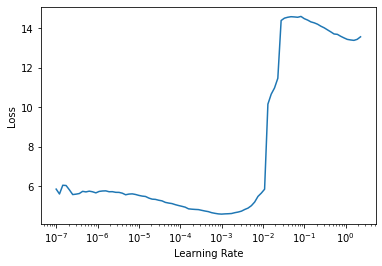

In [ ]:
#slow
learn.lr_find(suggestions=True)

In [ ]:
#slow
learn.fit_one_cycle(1, lr_max=4e-5, cbs=fit_cbs)

epoch,train_loss,valid_loss,bleu,meteor,sacrebleu,time
0,2.223296,2.126458,0.082567,0.288516,7.607020,02:10


In [ ]:
learn.show_results(learner=learn, input_trunc_at=500, target_trunc_at=500)

,text,target,prediction
0,"Sie wird aber auf Seite 5 dieser Leitlinien ganz eindeutig genannt, und ich möchte darauf verweisen - weil sie mich dazu aufgefordert haben -, daß diese Partnerschaft für mich - und ich habe lange genug eine Region betreut, um dies beurteilen zu können - ein sehr wirkungsvolles Instrument zur Mobilisierung der geistigen Ressourcen auf lokaler Ebene ist - sowohl derer im öffentlichen Sektor - die Stadt- und Gemeinderäte, den schulischen und gesellschaftlichen Bereich, die Vereine und Verbände -","However, I do wish to mention - since you have asked me to do so - that, as far as I am concerned, this partnership - and I spent long enough as a regional administrator within my own country to be able to say this most sincerely - is a tool, one used to involve local brainpower, be it in the public sector, in the form of elected representatives, the social and educational sectors, associations, or in the private sector; a decentralised partnership, and let me mention in this connection, in res","As you know, I would like to point out that, because I was asked to do so, this partnership is a very important one for me - and I have had a long-standing interest in it - and that it is an important instrument for the development of local communities, not only in the public sector but also in the private sector as well. And the territorial agreements which I have just mentioned are one of the forms of cooperation between me and Mrs Angelilli, for example, in the form of territorial agreements"
1,"Ich möchte daher die Kommission auf zwei Punkte hinweisen: Erstens muß die Konzertierung als Instrument der Koordinierung und der Beteiligung sämtlicher lokaler und regionaler Marktteilnehmer an den Entscheidungen optimal genutzt werden, um speziell Ungleichgewichte und Ungleichheiten zu vermeiden; zweitens bedarf es einer Vereinfachung und transparenteren Gestaltung der Verwaltungsprozesse, die sich allzu häufig unnötig in die Länge ziehen und derart kompliziert sind, daß sie, was vor allem vo","Firstly, we need to make the best possible use of consultation as a means of ensuring proper coordination and participation by all local and regional operators in decision-making, precisely so that imbalances and inequalities can be avoided. Secondly, a genuine effort is required to make administrative procedures simpler and more transparent, since, they are all too often unnecessarily lengthy and complicated, to the point of hindering access to the Funds.","I would like the Commission to focus on two points, firstly, on the importance of the Commission' s role as an instrument for the coordination and cooperation of local and regional stakeholders in the decision-making process, so as to ensure that there is a level of transparency and coordination in the implementation of the procedures, which are all too often difficult to implement and, in particular, because of the influence of the European Commission, the Commission has been a major factor in"


In [ ]:
test_de = "Ich trinke gerne Bier"

In [ ]:
outputs = learn.blurr_generate(test_de, num_return_sequences=3)

for idx, o in enumerate(outputs):
    print(f'=== Prediction {idx+1} ===\n{o}\n')

=== Prediction 1 ===
 I would like to make a beer, however, for the sake of beer, of course. I am a beer drinker, after all, and I like to drink a beer of some kind, as you do too, I would say, in a sense.

=== Prediction 2 ===
 I would like to make a beer, however, for the sake of beer, of course. I am a beer drinker, after all, and I like to drink a beer of some kind, as you do too, I would say, but not a beer.

=== Prediction 3 ===
 I would like to make a beer, however, for the sake of beer, of course. I am a beer drinker, after all, and I like to drink a beer of some kind, as you do too, I would say, in a way.



### Inference

In [ ]:
export_fname = 'translation_export'

In [ ]:
learn.metrics = None
learn.export(fname=f'{export_fname}.pkl')

In [ ]:
inf_learn = load_learner(fname=f'{export_fname}.pkl')
inf_learn.blurr_generate(test_de)

[' I would like to make a beer, however, for the sake of beer, of course. I am a beer drinker, after all, and I like to drink a beer of some kind, as you do too, I would say, in a sense.']

## Tests

The purpose of the following tests is to ensure as much as possible, that the core training code works for the pretrained **summarization models** below.  These tests are excluded from the CI workflow because of how long they would take to run and the amount of data that would be required to download.

**Note**: Feel free to modify the code below to test whatever pretrained summarization models you are working with ... and if any of your pretrained summarization models fail, please submit a github issue *(or a PR if you'd like to fix it yourself)*

In [ ]:
try: del learn; torch.cuda.empty_cache()
except: pass

In [ ]:
[ model_type for model_type in BLURR.get_models(task='ConditionalGeneration') 
 if (not model_type.__name__.startswith('TF')) ]

[transformers.models.bart.modeling_bart.BartForConditionalGeneration,
 transformers.models.blenderbot.modeling_blenderbot.BlenderbotForConditionalGeneration,
 transformers.models.blenderbot_small.modeling_blenderbot_small.BlenderbotSmallForConditionalGeneration,
 transformers.models.fsmt.modeling_fsmt.FSMTForConditionalGeneration,
 transformers.models.led.modeling_led.LEDForConditionalGeneration,
 transformers.models.m2m_100.modeling_m2m_100.M2M100ForConditionalGeneration,
 transformers.models.mbart.modeling_mbart.MBartForConditionalGeneration,
 transformers.models.mt5.modeling_mt5.MT5ForConditionalGeneration,
 transformers.models.pegasus.modeling_pegasus.PegasusForConditionalGeneration,
 transformers.models.prophetnet.modeling_prophetnet.ProphetNetForConditionalGeneration,
 transformers.models.speech_to_text.modeling_speech_to_text.Speech2TextForConditionalGeneration,
 transformers.models.t5.modeling_t5.T5ForConditionalGeneration,
 transformers.models.xlm_prophetnet.modeling_xlm_proph

In [ ]:
pretrained_model_names = [
    'facebook/bart-base',
    'facebook/wmt19-de-en',                      # FSMT
    'Helsinki-NLP/opus-mt-de-en',                # MarianMT
    #'sshleifer/tiny-mbart',
    #'google/mt5-small',
    't5-small'
]

In [ ]:
path = Path('./')
ds = load_dataset('wmt16', 'de-en', split='train[:1%]')
wmt_df = pd.DataFrame(ds['translation'], columns=['de', 'en']); len(wmt_df)
wmt_df = wmt_df.iloc[:1000]

Reusing dataset wmt16 (/home/wgilliam/.cache/huggingface/datasets/wmt16/de-en/1.0.0/7b2c4443a7d34c2e13df267eaa8cab4c62dd82f6b62b0d9ecc2e3a673ce17308)


In [ ]:
#slow
#hide_output
model_cls = AutoModelForSeq2SeqLM
bsz = 2
inp_seq_sz = 128; trg_seq_sz = 128

test_results = []
for model_name in pretrained_model_names:
    error=None
    
    print(f'=== {model_name} ===\n')
    
    hf_tok_kwargs = {}
    if (model_name == 'sshleifer/tiny-mbart'):
        hf_tok_kwargs['src_lang'], hf_tok_kwargs['tgt_lang'] = "de_DE", "en_XX"
            
    
    hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(model_name, 
                                                                      model_cls=model_cls, 
                                                                      tokenizer_kwargs=hf_tok_kwargs)
    
    print(f'architecture:\t{hf_arch}\ntokenizer:\t{type(hf_tokenizer).__name__}\nmodel:\t\t{type(hf_model).__name__}\n')
    
    # 1. build your DataBlock
    text_gen_kwargs = default_text_gen_kwargs(hf_config, hf_model, task='translation')
    
    def add_t5_prefix(inp): return f'translate German to English: {inp}' if (hf_arch == 't5') else inp
    
    before_batch_tfm = HF_Seq2SeqBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model,
                                                      padding='max_length', 
                                                      max_length=inp_seq_sz, 
                                                      max_target_length=trg_seq_sz, 
                                                      text_gen_kwargs=text_gen_kwargs)
    
    blocks = (HF_Seq2SeqBlock(before_batch_tfm=before_batch_tfm), noop)
    dblock = DataBlock(blocks=blocks, 
                   get_x=Pipeline([ColReader('de'), add_t5_prefix]), 
                   get_y=ColReader('en'), 
                   splitter=RandomSplitter())

    dls = dblock.dataloaders(wmt_df, bs=bsz) 
    b = dls.one_batch()

    # 2. build your Learner
    seq2seq_metrics = {}
    
    model = HF_BaseModelWrapper(hf_model)
    fit_cbs = [
        ShortEpochCallback(0.05, short_valid=True), 
        HF_Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)
    ]

    learn = Learner(dls, 
                    model,
                    opt_func=ranger,
                    loss_func=HF_PreCalculatedLoss(),
                    cbs=[HF_BaseModelCallback],
                    splitter=partial(seq2seq_splitter, arch=hf_arch)).to_fp16()

    learn.create_opt() 
    learn.freeze()
    
    # 3. Run your tests
    try:
        print('*** TESTING DataLoaders ***\n')
        test_eq(len(b), 2)
        test_eq(len(b[0]['input_ids']), bsz)
        test_eq(b[0]['input_ids'].shape, torch.Size([bsz, inp_seq_sz]))
        test_eq(len(b[1]), bsz)

#         print('*** TESTING One pass through the model ***')
#         preds = learn.model(b[0])
#         test_eq(preds[1].shape[0], bsz)
#         test_eq(preds[1].shape[2], hf_config.vocab_size)

        print('*** TESTING Training/Results ***')
        learn.fit_one_cycle(1, lr_max=1e-3, cbs=fit_cbs)

        test_results.append((hf_arch, type(hf_tokenizer).__name__, type(hf_model).__name__, 'PASSED', ''))
        learn.show_results(learner=learn, max_n=2, input_trunc_at=500, target_trunc_at=250)
    except Exception as err:
        test_results.append((hf_arch, type(hf_tokenizer).__name__, type(hf_model).__name__, 'FAILED', err))
    finally:
        # cleanup
        del learn; torch.cuda.empty_cache()

=== facebook/bart-base ===

architecture:	bart
tokenizer:	BartTokenizerFast
model:		BartForConditionalGeneration

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


,text,target,prediction
0,"Aus diesem Grund ist es eines der wichtigsten und weitreichendsten Ziele, die wir uns in der Europäischen Union stellen sollten, Anstrengungen zur Schaffung neuer Arbeitsplätze in den ländlichen Gebieten außerhalb des Agrarsektors zu unternehmen, unter anderem in den Bereichen ländlicher Tourismus, Sport, Kultur, Sanierung der Ressourcen,","For this reason, one of the most important and essential objectives which we should set in the European Union is to make efforts to create new jobs in rural areas, outside of the agricultural sector, in sectors such as rural tourism, sport, culture,",Aus diesem Grund ist es eines der wichtigsten und we
1,"Angesichts dessen müssen wir in diesem Parlament auf jeden Fall verlangen, daß die gemeinschaftlichen Förderkonzepte für den fraglichen Zeitraum in diesem Parlament vor ihrer Annahme geprüft und erörtert werden, und zwar anhand der Leitlinien, die wir heute vorlegen, denn wir halten sie für ganz besonders geeignet, Arbeits","Bearing this in mind, this House should, in any event, demand that, before the Community support frameworks for the period in question are approved, they be studied and submitted for debate in this Parliament, specifically in light of the guidelines",Angesichts dessen müssen wir in diesem Parlam


=== facebook/wmt19-de-en ===

architecture:	fsmt
tokenizer:	FSMTTokenizer
model:		FSMTForConditionalGeneration

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


,text,target,prediction
0,"Aus diesem Grund ist es eines der wichtigsten und weitreichendsten Ziele, die wir uns in der Europäischen Union stellen sollten, Anstrengungen zur Schaffung neuer Arbeitsplätze in den ländlichen Gebieten außerhalb des Agrarsektors zu unternehmen, unter anderem in den Bereichen ländlicher Tourismus, Sport, Kultur, Sanierung der Ressourcen, Umstellung von Unternehmen, neue Technologien, Dienstleistungen usw. Doch obwohl die Landwirtschaft keine ausschließliche Rolle mehr spielt, ist sie weiterhin","For this reason, one of the most important and essential objectives which we should set in the European Union is to make efforts to create new jobs in rural areas, outside of the agricultural sector, in sectors such as rural tourism, sport, culture,","For this reason, one of the most important and far-reaching objectives that we in the European Union should set ourselves is to make an effort to create new jobs in rural areas outside the agricultural sector, including rural tourism, sport, culture,"
1,"Da meine Fraktion der Meinung ist, daß ein Parlament dazu da ist, zuzuhören, zu diskutieren und nachzudenken, gibt es unserer Ansicht nach keinen Grund zur Rechtfertigung dieser Verzögerung, und wir glauben, wenn die Kommission dazu in der Lage ist, liegen wir genau in der Zeit, um die ursprüngliche Vereinbarung zwischen dem Parlament und der Kommission wieder in Kraft zu setzen und verantwortungsbewußt vor unsere Mitbürgerinnen und Mitbürgern treten zu können.","My Group believes that since a parliament is meant to listen, debate and reflect, there can be no justification whatsoever for this delay and we believe that, if the Commission is ready to do so, we still have time to re-establish the original agreem","Since my group believes that a Parliament exists to listen, debate and reflect, we believe that there is no reason to justify this delay, and we believe that if the Commission is able to do so, we will be in exactly the right time to re-enter into fo"


=== Helsinki-NLP/opus-mt-de-en ===

architecture:	marian
tokenizer:	MarianTokenizer
model:		MarianMTModel

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


,text,target,prediction
0,"Die▁Verkehrssicherheit▁bestimmte in▁letzter Zeit▁häufig die▁Negativschlagzeilen: Das▁Eisenbahnunglück▁nahe dem▁Londoner▁Bahnhof Paddington, das▁furchtbare▁Eisenbahnunglück in▁Norwegen,▁zwei▁Flugzeugabstürze,▁bei▁denen EU-Bürger zu▁Schaden▁kamen, und die von der Erika vor der bretonischen▁Küste▁verursachte Naturkatastrophe▁sind▁Ereignisse, die▁allein in den▁letzten▁vier▁Monaten zu▁verzeichnen▁waren. Sie▁machen▁deutlich,▁daß▁Verkehrssicherheit▁keine▁Selbstverständlichkeit▁ist und▁daß▁diejenigen, d","Transport safety has sadly been in the news recently: the Paddington rail crash in London, the terrible rail crash in Norway, the two aviation crashes involving EU citizens and the natural disaster involving the Erika off Brittany - all within the la","In recent years, road safety has often defined the negative headlines: the railway accident near London's Paddington station, the terrible railway accident in Norway, two aircraft crashes causing damage to EU citizens, and the natural disaster caused"
1,"▁Diese▁Änderungen,▁sollten▁sie▁heute von▁diesem Hohen Haus▁angenommen▁werden,▁sind▁meiner▁Ansicht nach ein▁weiterer▁entscheidender▁Schritt zur▁Erreichung der▁historisch▁bedeutsamen▁Ziele, für die die▁Fonds▁ursprünglich▁eingerichtet▁worden▁waren,▁nämlich die▁finanziell▁nachhaltige▁Unterstützung der▁benachteiligten▁Gebiete in der▁Europäischen Union, in der der▁Lebensstandard nicht durch Almosen,▁sondern▁konkrete▁Hilfe auf ein▁menschenwürdiges▁Niveau▁angehoben▁werden▁muß.","If these changes to the report are supported by the House today, I believe that they will move us forward in the next phase of achieving the historic objectives which the funds were set up to bring about, namely to assist - in a financially sustainab","These changes, if adopted by this House today, are, in my view, a further decisive step towards achieving the historically important objectives for which the funds were originally set up, namely the financially sustainable support of the less-favoure"


=== t5-small ===

architecture:	t5
tokenizer:	T5TokenizerFast
model:		T5ForConditionalGeneration

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


,text,target,prediction
0,"translate German to English: Angesichts dessen müssen wir in diesem Parlament auf jeden Fall verlangen, daß die gemeinschaftlichen Förderkonzepte für den fraglichen Zeitraum in diesem Parlament vor ihrer Annahme geprüft und erörtert werden, und zwar anhand der Leitlinien, die wir heute vorlegen, denn wir halten sie für ganz besonders geeignet, Arbeitsplätze in den ärmsten oder am wenigsten entwickelten Regionen zu schaffen, und so tragen wir dazu bei, den negativen, zur Ungleichheit führenden Te","Bearing this in mind, this House should, in any event, demand that, before the Community support frameworks for the period in question are approved, they be studied and submitted for debate in this Parliament, specifically in light of the guidelines","Angesichts dessen müssen wir in diesem Parlament auf jeden Fall verlangen, daß"
1,"translate German to English: Herr Präsident! In erster Linie möchte ich den Berichterstatter, Herrn Koch, zu seiner großartigen Arbeit und seiner konstruktiven Zusammenarbeit mit der Kommission bei der Verbesserung der Texte, der Vorlage dieses Berichts und dieses Vorschlags beglückwünschen; letztendlich gibt es nur einen nderungsantrag in bezug auf die Anforderungen an die Prüfungsvorschriften für Sicherheitsberater für die Beförderung gefährlicher Güter auf Straße, Schiene oder Binnenwasserstr","Mr President, I would firstly like to congratulate the rapporteur, Mr Koch, on his magnificent work and his positive cooperation with the Commission with regard to improving the texts and presenting this report and this proposal; in the end there is","In erster Linie möchte ich den Berichterstatter, Herrn Koch, zu seiner"


In [ ]:
#slow
#hide_input
test_results_df = pd.DataFrame(test_results, columns=['arch', 'tokenizer', 'model_name', 'result', 'error'])
display_df(test_results_df)

,arch,tokenizer,model_name,result,error
0,bart,BartTokenizerFast,BartForConditionalGeneration,PASSED,
1,fsmt,FSMTTokenizer,FSMTForConditionalGeneration,PASSED,
2,marian,MarianTokenizer,MarianMTModel,PASSED,
3,t5,T5TokenizerFast,T5ForConditionalGeneration,PASSED,


## Cleanup

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01a_data-token-classification.ipynb.
Converted 01b_data-question-answering.ipynb.
Converted 01za_data-seq2seq-core.ipynb.
Converted 01zb_data-seq2seq-language-modeling.ipynb.
Converted 01zc_data-seq2seq-summarization.ipynb.
Converted 01zd_data-seq2seq-translation.ipynb.
Converted 02_modeling-core.ipynb.
Converted 02a_modeling-token-classification.ipynb.
Converted 02b_modeling-question-answering.ipynb.
Converted 02za_modeling-seq2seq-core.ipynb.
Converted 02zb_modeling-seq2seq-language-modeling.ipynb.
Converted 02zc_modeling-seq2seq-summarization.ipynb.
Converted 02zc_modeling-seq2seq-translation.ipynb.
Converted 99a_examples-multilabel.ipynb.
Converted index.ipynb.
